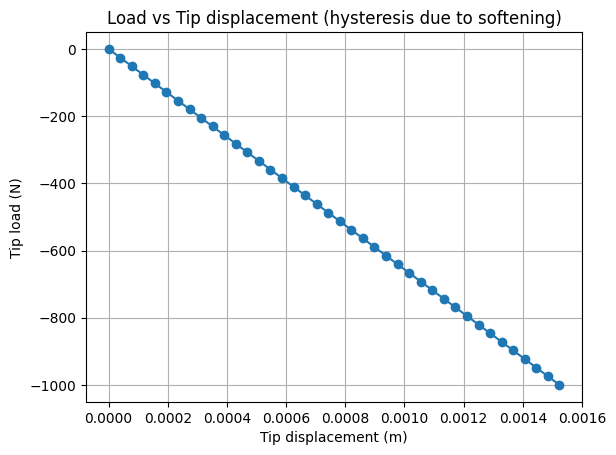

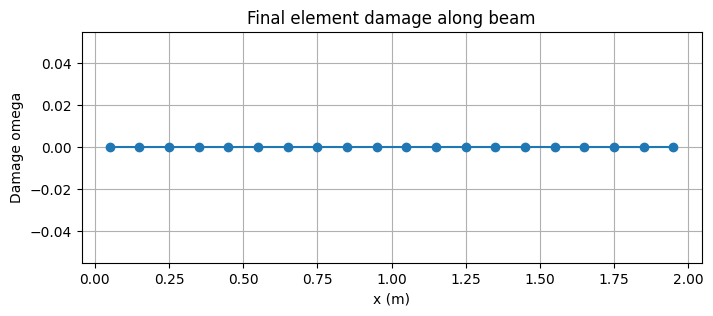

Max moment encountered (N*m): 1949.9999999981258
Final tip displacement (m): 0.0015238704786272182


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# Beam and mesh
L = 2.0        # length (m)
n_el = 20
n_node = n_el + 1
x = np.linspace(0, L, n_node)
Le = L / n_el

# Material
E = 210e9      # Pa
I = 8.333e-6   # m^4
My = 2000.0    # yield moment (N*m)
eps_f = 0.05   # softening param

def elem_kb(E, I, L):
    k = E*I / (L**3)
    return k * np.array([
        [12,   6*L,  -12,  6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L,  12,  -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])

ndof = 2*n_node
fixed = [0,1]  # cantilever at left node

P_max = -1000.0  # N
n_steps = 40
P_vals = np.linspace(0.0, P_max, n_steps)

elem_alpha = np.zeros(n_el)
elem_omega = np.zeros(n_el)

def assemble_K(omegas):
    K = sp.lil_matrix((ndof, ndof))
    for e in range(n_el):
        kb = elem_kb(E, I, Le)
        k_local = (1.0 - omegas[e]) * kb
        n1 = e
        n2 = e+1
        dofs = [2*n1, 2*n1+1, 2*n2, 2*n2+1]
        for i in range(4):
            for j in range(4):
                K[dofs[i], dofs[j]] += k_local[i,j]
    return K.tocsr()

def element_mid_moment(U, e, omegas):
    kb = elem_kb(E, I, Le)
    k_local = (1.0 - omegas[e]) * kb
    n1 = e; n2 = e+1
    dofs = [2*n1, 2*n1+1, 2*n2, 2*n2+1]
    ue = np.array([U[dofs[0]], U[dofs[1]], U[dofs[2]], U[dofs[3]]])
    theta1 = ue[1]; theta2 = ue[3]
    kappa = (theta2 - theta1) / Le
    M = E * I * kappa
    return M

U = np.zeros(ndof)
U_hist = []
Mmax_hist = []
omega_hist = []

for step, P in enumerate(P_vals):
    K = assemble_K(elem_omega)
    F = np.zeros(ndof)
    F[-2] = P
    free = [i for i in range(ndof) if i not in fixed]
    Kff = K[free,:][:,free]
    Ff = F[free]
    Uf = spla.spsolve(Kff.tocsr(), Ff)
    U_new = U.copy()
    for i, dof in enumerate(free):
        U_new[dof] = Uf[i]
    Mmax = 0.0
    for e in range(n_el):
        M = element_mid_moment(U_new, e, elem_omega)
        Mmax = max(Mmax, abs(M))
        if abs(M) > My:
            excess = abs(M) - My
            delta_alpha = excess / (E*I/Le)
            elem_alpha[e] += delta_alpha
            elem_omega[e] = 1.0 - np.exp(-elem_alpha[e] / eps_f)
            if elem_omega[e] > 0.9999:
                elem_omega[e] = 0.9999
    U = U_new
    U_hist.append(U.copy())
    Mmax_hist.append(Mmax)
    omega_hist.append(elem_omega.copy())

tip_disp = [-U_hist[i][-2] for i in range(len(U_hist))]
Pvals = P_vals[:len(tip_disp)]
plt.figure()
plt.plot(tip_disp, Pvals, marker='o')
plt.xlabel('Tip displacement (m)')
plt.ylabel('Tip load (N)')
plt.title('Load vs Tip displacement (hysteresis due to softening)')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,3))
positions = [(i+0.5)*Le for i in range(n_el)]
plt.plot(positions, elem_omega, '-o')
plt.xlabel('x (m)')
plt.ylabel('Damage omega')
plt.title('Final element damage along beam')
plt.grid(True)
plt.show()

print("Max moment encountered (N*m):", max(Mmax_hist))
print("Final tip displacement (m):", tip_disp[-1])

Final tip displacement (m): 8.481418366632819e-09
Max damage: 0.0


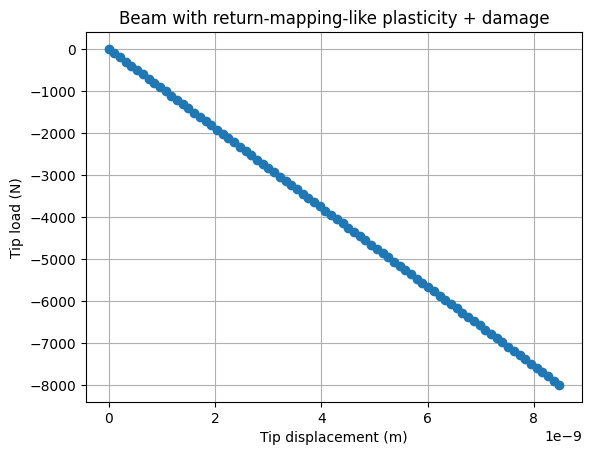

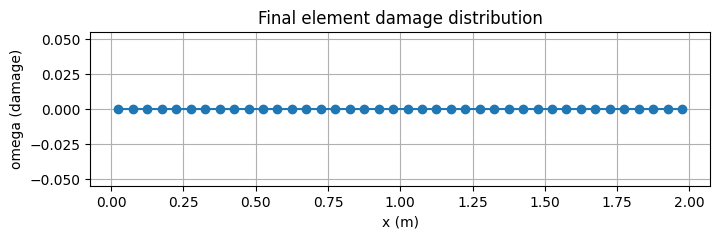

In [ ]:
# beam_return_mapping_damage.py
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

# Mesh & geometry
L = 2.0
n_el = 40
n_node = n_el + 1
x = np.linspace(0, L, n_node)
Le = L / n_el

# Material params (tune these)
E = 210e9       # Pa
I = 8.333e-6    # m^4
My = 5000.0     # yield moment (N*m)
H = 1e5         # hardening parameter (N*m per unit alpha)
eps_f = 0.02    # damage softening parameter

# element stiffness pattern normalized by (1/Le^3)
def elem_kb_matrix(L):
    return np.array([
        [12,   6*L,  -12,  6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L,  12,  -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ]) / (L**3)

K_pattern = elem_kb_matrix(Le)

# State arrays per element
elem_kappa_p = np.zeros(n_el)   # plastic curvature
elem_alpha_p = np.zeros(n_el)   # plastic internal scalar
elem_alpha_d = np.zeros(n_el)   # softening internal variable
elem_omega = np.zeros(n_el)     # damage

# load increments
P_max = -8000.0   # tip downward load (try larger to trigger yielding)
n_steps = 80
P_vals = np.linspace(0.0, P_max, n_steps)

ndof = 2 * n_node
fixed = [0,1]  # cantilever left node fixed (w=0,theta=0)
U = np.zeros(ndof)
U_hist = []
omega_hist = []
Mmid_hist = []

sqrt23 = np.sqrt(2.0/3.0)

for step, P in enumerate(P_vals):
    # assemble global stiffness using element tangents
    K = sp.lil_matrix((ndof, ndof))
    for e in range(n_el):
        # compute curvature kappa from current U
        n1 = e; n2 = e+1
        theta1 = U[2*n1+1]; theta2 = U[2*n2+1]
        kappa = (theta2 - theta1) / Le
        # trial moment
        M_tr = E*I*(kappa - elem_kappa_p[e])
        f_tr = abs(M_tr) - (My + H*elem_alpha_p[e])
        # constitutive update
        if f_tr <= 1e-12:
            # elastic
            M = (1.0 - elem_omega[e]) * M_tr
            D = (1.0 - elem_omega[e]) * E * I  # tangent dM/dkappa
        else:
            # plastic correction (simple scalar solve)
            s = np.sign(M_tr) if M_tr != 0 else 1.0
            a = (1.0 - elem_omega[e]) * E * I + s * H * sqrt23
            b = (1.0 - elem_omega[e]) * E * I * (kappa - elem_kappa_p[e]) - s * (My + H * elem_alpha_p[e])
            dg = b / a
            if dg < 0:
                dg = 0.0
            # update internal variables
            elem_kappa_p[e] += dg
            elem_alpha_p[e] += sqrt23 * dg
            elem_alpha_d[e] += sqrt23 * dg
            # updated moment and tangent (approx)
            M = s * (My + H * elem_alpha_p[e]) * (1.0 - elem_omega[e])
            # approximate tangent reduction due to plasticity
            D = (1.0 - elem_omega[e]) * E * I / (1.0 + (s * H * sqrt23) / ((1.0 - elem_omega[e]) * E * I + 1e-18))
        # update damage
        elem_omega[e] = 1.0 - np.exp(-elem_alpha_d[e] / eps_f) if eps_f > 0 else 0.0
        elem_omega[e] = min(elem_omega[e], 0.9999)
        # element stiffness: K_pattern * D
        Ke = K_pattern * D
        dofs = [2*n1, 2*n1+1, 2*n2, 2*n2+1]
        for i_local, I in enumerate(dofs):
            for j_local, Jcol in enumerate(dofs):
                K[I,Jcol] += Ke[i_local,j_local]
    # external force vector (point load at tip vertical DOF)
    F = np.zeros(ndof)
    F[-2] = P
    free = [i for i in range(ndof) if i not in fixed]
    Kff = K[free,:][:,free].tocsr()
    Ff = F[free]
    Uf = spla.spsolve(Kff, Ff)
    U_new = U.copy()
    for i, dof in enumerate(free):
        U_new[dof] = Uf[i]
    U = U_new
    U_hist.append(U.copy())
    omega_hist.append(elem_omega.copy())
    # compute midspan moment distribution
    Mmid = np.zeros(n_el)
    for e in range(n_el):
        n1 = e; n2 = e+1
        theta1 = U[2*n1+1]; theta2 = U[2*n2+1]
        kappa = (theta2 - theta1) / Le
        Mmid[e] = (1.0 - elem_omega[e]) * E * I * (kappa - elem_kappa_p[e])
    Mmid_hist.append(Mmid.copy())

# Postprocess
tip_disp = -U_hist[-1][-2]
print("Final tip displacement (m):", tip_disp)
print("Max damage:", np.max(elem_omega))

# Plot
loads = P_vals[:len(U_hist)]
tip_disps = [-U_hist[i][-2] for i in range(len(U_hist))]
plt.figure()
plt.plot(tip_disps, loads, '-o')
plt.xlabel('Tip displacement (m)')
plt.ylabel('Tip load (N)')
plt.title('Beam with return-mapping-like plasticity + damage')
plt.grid(True)
plt.show()

positions = [(i+0.5)*Le for i in range(n_el)]
plt.figure(figsize=(8,2))
plt.plot(positions, elem_omega, '-o')
plt.xlabel('x (m)')
plt.ylabel('omega (damage)')
plt.title('Final element damage distribution')
plt.grid(True)
plt.show()

Finished mesh: 10 elements
Finished mesh: 20 elements
Finished mesh: 40 elements
Finished mesh: 80 elements


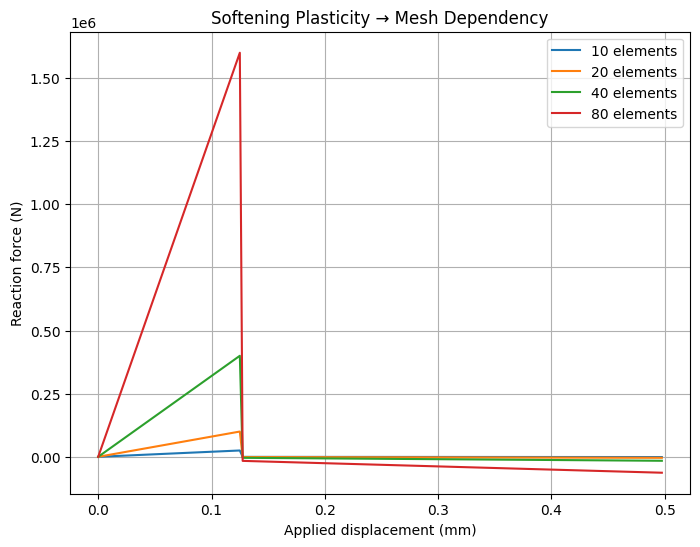

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# PARAMETERS
# -----------------------------
E = 200e3         # Young modulus (MPa)
A = 1.0           # Area (mm²)
sigma_y = 250.0   # Yield stress (MPa)
H = -2000.0       # Softening modulus (MPa) (negative -> softening)
u_max = 0.5       # Maximum imposed displacement (mm)
n_steps = 200     # Load steps

# ----------------------------------------
# ELASTO-PLASTIC CONSTITUTIVE LAW
# ----------------------------------------
def update_stress(strain, eps_p):
    """
    Returns:
      sigma, new_eps_p, tangent_modulus
    """
    # trial stress
    sigma_tr = E * (strain - eps_p)

    # yield function
    f_tr = abs(sigma_tr) - (sigma_y + H * eps_p)

    if f_tr <= 0:
        # elastic step
        return sigma_tr, eps_p, E

    # plastic correction
    dgamma = f_tr / (E - H)
    new_eps_p = eps_p + dgamma * np.sign(sigma_tr)
    sigma = E*(strain - new_eps_p)
    tangent = (E * H) / (E - H)  # consistent tangent

    return sigma, new_eps_p, tangent


# ----------------------------------------
# 1D BAR FE ROUTINE
# ----------------------------------------
def run_fe(n_el):
    L = 100.0  # length (mm)
    nodes = n_el + 1
    h = L / n_el

    # gauss point states
    eps_p = np.zeros(n_el)

    # storage for curves
    U_hist = []
    F_hist = []

    for step in range(n_steps):
        u = u_max * step / n_steps

        # global stiffness + internal force
        K = 0.0
        Finternal = 0.0

        # --- 1D two-node element, uniform strain ---
        for e in range(n_el):
            strain = u / L  # engineering strain

            sigma, eps_p[e], D = update_stress(strain, eps_p[e])

            # element stiffness and internal force
            Ke = A * D / h
            Fe = sigma * A

            K += Ke
            Finternal += Fe

        # solve reaction force
        F = K * u

        U_hist.append(u)
        F_hist.append(F)

    return np.array(U_hist), np.array(F_hist)


# ----------------------------------------
# RUN MULTIPLE MESHES
# ----------------------------------------
meshes = [10, 20, 40, 80]
results = {}

for ne in meshes:
    U, F = run_fe(ne)
    results[ne] = (U, F)
    print(f"Finished mesh: {ne} elements")

# ----------------------------------------
# PLOT RESULTS
# ----------------------------------------
plt.figure(figsize=(8,6))
for ne in meshes:
    U, F = results[ne]
    plt.plot(U, F, label=f"{ne} elements")

plt.xlabel("Applied displacement (mm)")
plt.ylabel("Reaction force (N)")
plt.title("Softening Plasticity → Mesh Dependency")
plt.legend()
plt.grid(True)
plt.show()